In [1]:
from tr_kfac_opt import KFACOptimizer
%load_ext autoreload
%autoreload 2

In [2]:
import ray
ray.init(num_cpus=50, num_gpus=1)

2020-12-14 00:36:36,364	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8268


{'node_ip_address': '128.10.8.32',
 'raylet_ip_address': '128.10.8.32',
 'redis_address': '128.10.8.32:62496',
 'object_store_address': '/tmp/ray/session_2020-12-14_00-36-35_554989_46646/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-14_00-36-35_554989_46646/sockets/raylet',
 'webui_url': '127.0.0.1:8268',
 'session_dir': '/tmp/ray/session_2020-12-14_00-36-35_554989_46646',
 'metrics_export_port': 58564,
 'node_id': '744fbfc907a6100553f67ec8564edf524b52cdb9'}

In [3]:
import CoRec
import gym
import numpy as np

import stable_baselines3 as sb3
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from ray import tune

from ppo_fitre import FitrePPO, FitreMlpPolicy

import warnings
warnings.filterwarnings("ignore")

/u/antor/u24/yuan294/speedtest/speed_venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/u/antor/u24/yuan294/speedtest/speed_venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/u/antor/u24/yuan294/speedtest/speed_venv/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/u/a

In [4]:
class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reward(self, r):
        if r <= -1:
            r = 0
        else:
            r += 0.1

        return r

In [5]:
def ppo_hyper(**kwargs): return kwargs

config = ppo_hyper(
    # learning_rate=tune.loguniform(1e-6, 0.01),  # learning rate doesn't make a difference in FITRE
    learning_rate = 1e-4,
    n_steps=tune.choice([256, 512, 1024, 2048, 4096]),
    batch_size=tune.choice([32, 64, 128, 256, 512, 1024, 2048]),
    n_epochs=tune.randint(4, 32),
    gamma=tune.uniform(0.95, 1),
    gae_lambda=tune.uniform(0.95, 0.999),
    clip_range=tune.uniform(0.01, 0.5),
    clip_range_vf=None,
    ent_coef=0.05,
    vf_coef=tune.uniform(0.2, 0.8),
    max_grad_norm=0.5,
    use_sde=False,
    sde_sample_freq=-1,
    target_kl=None,
    seed=1
)
    
config

{'learning_rate': 0.0001,
 'n_steps': <ray.tune.sample.Categorical at 0x7f1a8014c4a8>,
 'batch_size': <ray.tune.sample.Categorical at 0x7f1a8014c550>,
 'n_epochs': <ray.tune.sample.Integer at 0x7f1a8014c518>,
 'gamma': <ray.tune.sample.Float at 0x7f1a8014c5f8>,
 'gae_lambda': <ray.tune.sample.Float at 0x7f1a8014c668>,
 'clip_range': <ray.tune.sample.Float at 0x7f1a8014c6d8>,
 'clip_range_vf': None,
 'ent_coef': 0.05,
 'vf_coef': <ray.tune.sample.Float at 0x7f1a8014c748>,
 'max_grad_norm': 0.5,
 'use_sde': False,
 'sde_sample_freq': -1,
 'target_kl': None,
 'seed': 1}

In [6]:
def env_func(): return RewardWrapper(gym.make("F16GCAS-v3"))

env = make_vec_env(env_func, n_envs=4)
# model = PPO(MlpPolicy, env, verbose=1)

## Only change is here
see <--

In [7]:
class ReportCallback(sb3.common.callbacks.BaseCallback):
    def __init__(self, verbose=0):
        super(ReportCallback, self).__init__(verbose)
        
    def _on_rollout_end(self) -> None:
        ep_rewards = [ep_info["r"] for ep_info in self.model.ep_info_buffer]
        ep_rew_mean = np.mean(ep_rewards)
        tune.report(ep_rew = ep_rew_mean)
    
    def _on_step(self) -> bool:
        return True
    
def F16_train(config):
    callback = ReportCallback()
    model = FitrePPO(FitreMlpPolicy, env, verbose=1, **config)
    model.policy.optimizer = KFACOptimizer(model.policy) # <-- Plugin here!
    model.learn(total_timesteps=500000, callback=callback)
    model.save("fitre_f16")
    
analysis = tune.run(F16_train, config=config, num_samples=50, verbose=1, metric="ep_rew", mode="max", raise_on_failed_trial=False)

Trial name,status,loc,batch_size,clip_range,gae_lambda,gamma,n_epochs,n_steps,vf_coef,iter,total time (s),ep_rew
F16_train_58d66_00000,TERMINATED,,2048,0.257664,0.955613,0.972738,19,512,0.415995,245,1064.96,17.0522
F16_train_58d66_00001,TERMINATED,,512,0.381036,0.972889,0.976615,26,2048,0.791158,62,1453.93,70.9184
F16_train_58d66_00002,TERMINATED,,2048,0.322806,0.968418,0.990744,6,256,0.448122,489,898.734,90.671
F16_train_58d66_00003,TERMINATED,,128,0.123814,0.95593,0.978082,7,512,0.261675,245,1303.61,64.2942
F16_train_58d66_00004,TERMINATED,,128,0.270669,0.990011,0.958377,27,256,0.462671,489,2399.15,77.0582
F16_train_58d66_00005,TERMINATED,,512,0.221166,0.958072,0.984176,24,512,0.237848,245,1408.79,63.3747
F16_train_58d66_00006,TERMINATED,,1024,0.442047,0.974617,0.959666,29,2048,0.692063,62,1312.99,17.0049
F16_train_58d66_00007,TERMINATED,,256,0.437973,0.985808,0.95275,10,1024,0.385646,123,1216.69,73.1564
F16_train_58d66_00008,TERMINATED,,1024,0.424615,0.959047,0.995093,28,256,0.410718,489,1315.81,105.843
F16_train_58d66_00009,TERMINATED,,128,0.293421,0.968343,0.998102,31,4096,0.405469,31,2669.31,69.0935


2020-12-14 02:25:20,459	INFO tune.py:439 -- Total run time: 6517.78 seconds (6517.46 seconds for the tuning loop).


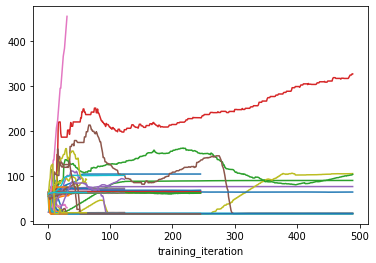

In [8]:
ax = None
dfs = analysis.trial_dataframes
for d in dfs.values():
    ax = d.plot("training_iteration", "ep_rew", ax=ax, legend=False)

In [9]:
analysis.get_best_config(metric="ep_rew", mode="max")

{'learning_rate': 0.0001,
 'n_steps': 4096,
 'batch_size': 256,
 'n_epochs': 7,
 'gamma': 0.9668635423551165,
 'gae_lambda': 0.9548200760044657,
 'clip_range': 0.17389655266130066,
 'clip_range_vf': None,
 'ent_coef': 0.05,
 'vf_coef': 0.7300873431227772,
 'max_grad_norm': 0.5,
 'use_sde': False,
 'sde_sample_freq': -1,
 'target_kl': None,
 'seed': 1}

In [10]:
import seaborn as sns
import pandas as pd

new_frame = []
for d in dfs.values():
    new_frame.append(pd.concat([d["training_iteration"], d["ep_rew"]], axis=1))

new_frame = pd.concat(new_frame, axis=0)
new_frame.insert(2, "algo", "fitre")
new_frame.to_csv("rl_train_res/fitre.csv")
new_frame.head()

,training_iteration,ep_rew,algo
0,1,NaN,fitre
1,2,63.048410,fitre
2,3,58.648420,fitre
3,4,59.895480,fitre
4,5,60.878649,fitre


<AxesSubplot:xlabel='training_iteration', ylabel='ep_rew'>

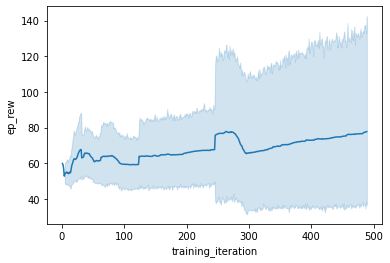

In [11]:
sns.lineplot(data=new_frame, x="training_iteration", y="ep_rew")

<AxesSubplot:xlabel='training_iteration'>

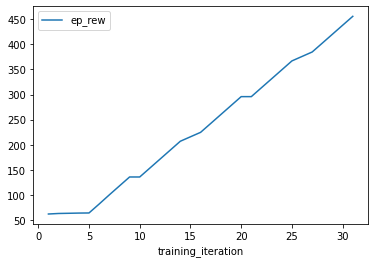

In [12]:
analysis.best_dataframe.plot("training_iteration", "ep_rew")